# Root Cause Discovery + Lasso

Here for a known "root cause gene", lets run a Lasso regression to filter down the number of features, before running Root Cause Discovery algorithm

+ After processing, we obtained 2 datasets
    1. "Interventional data": there are 32 samples for which we have ground truth data. Each row is a gene and each column is a sample. 
    2. "observational data": these are a few hundred samples for which we did not do any intervention. Each row is a gene and each column is a sample.
+ The main idea is that an intervention supposedly caused a disturbance in gene expression, so we can compare the data of intervention to baseline (i.e. observational data), and try to which gene is most differentially expressed

In [1]:
# using Pkg
# Pkg.update("RootCauseDiscovery")

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using ProgressMeter
using LinearAlgebra
BLAS.set_num_threads(1)

using Plots
gr(fmt=:png)

# import RootCauseDiscovery.zscore
# import RootCauseDiscovery.compute_permutations
# import RootCauseDiscovery.root_cause_discovery
# import RootCauseDiscovery.find_largest
# import RootCauseDiscovery.find_second_largest

# using Statistics
# import StatsBase.cov2cor
# using GLMNet
# using CovarianceEstimation
# using LinearAlgebra
# using Plots
# gr(fmt=:png)
# include("/home/users/bbchu/RootCauseDiscovery/utilities.jl")

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, 
        total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

function make_plot(
        Z_score_rank::AbstractVector, 
        RCD_rank::AbstractVector, 
        patient_name::AbstractVector;
        plot1_ymax = 5500,
        plot2_ymin = -2500,
        plot2_ymax = 2500,
        title1 = "Root cause rank (Z-score vs Cholesky score)",
        title2 = "Original Z score rank - refined Z score rank"
    )
    # sort by diff in Z scores
    Z_score_diff = Z_score_rank - RCD_rank
    perm = sortperm(Z_score_diff)

    #
    # plot 1
    #
    plt1 = scatter(
        1:length(patient_name), 
        Z_score_rank[perm], 
        ylabel="rank", 
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        label = "Original z-score rank",
        title = title1,
        legend=:top,
        dpi=300,
        ylim=(0, plot1_ymax)
    )
    scatter!(plt1, 1:length(patient_name), RCD_rank[perm], label="Refined Z-score rank")

    #
    # plot 2
    #
    palettes = theme_palette(:auto)
    my_colors = []
    for i in eachindex(Z_score_diff)
        if isinf(Z_score_diff[i])
            push!(my_colors, :black)
            Z_score_diff[i] = plot2_ymin
        elseif Z_score_diff[i] > 0
            push!(my_colors, palettes[1])
        elseif Z_score_diff[i] == 0
            push!(my_colors, palettes[3])
        else
            push!(my_colors, palettes[2])
        end
    end

    # make plot
    plt2 = scatter(
        1:length(patient_name_success), 
        Z_score_diff[perm],
        title=title2, 
        ylabel="Rank difference",
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        ylim=(plot2_ymin, plot2_ymax),
        label = nothing,
        legend=:outerbottom,
        color=my_colors[perm],
        dpi=300,
    )
    hline!(plt2, [0], color=:black, linestyle=:dash, label=nothing)

    #
    # combine plots
    #
    return plot(plt1, plt2, layout = (2, 1), size=(800, 600))
end

make_plot (generic function with 1 method)

## Read processed data
First, read in data and log (base 2) transform them

In [3]:
low_count = 10
threshold = 0.1
dir = "/scratch/users/bbchu/RootCauseDiscovery/7.29.2024/data"

# this example succeeded for all patients
# low_count = 5
# threshold = 0.1
# dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.31.2024/data"

# read processed data
isdir(dir) || mkpath(dir)
trainsform_int_file = joinpath(dir, "transform_int")
transform_obs_file = joinpath(dir, "transform_obs")
ground_truth_file = joinpath(dir, "ground_truth")

if !(isfile(trainsform_int_file) && isfile(transform_obs_file) && isfile(ground_truth_file))
    # process raw data & save
    transform_int, transform_obs, ground_truth = QC_gene_expression_data(;
        low_count = low_count, threshold = threshold)
    CSV.write(trainsform_int_file, transform_int)
    CSV.write(transform_obs_file, transform_obs)
    CSV.write(ground_truth_file, ground_truth)
else
    transform_int = CSV.read(trainsform_int_file, DataFrame)
    transform_obs = CSV.read(transform_obs_file, DataFrame)
    ground_truth = CSV.read(ground_truth_file, DataFrame)
end

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


32×19736 transpose(::Matrix{Float64}) with eltype Float64:
 7.16243  7.52393  6.15732  5.75861  6.71062  …  4.2431    0.875808   5.86397
 7.28255  7.48436  5.72704  6.77764  6.82252     3.82992  -0.0412821  6.12833
 7.12138  7.70363  6.29695  5.83796  8.2672      4.5615   -0.358486   6.02333
 7.32937  7.57685  5.63371  5.66632  7.63302     4.19641   0.43521    5.80585
 7.31479  7.64937  5.95707  5.71676  7.53938     4.37997  -0.0973676  6.23057
 7.95855  7.62452  6.30952  5.60984  7.64743  …  4.83117   0.582672   5.7784
 6.8259   7.12483  5.88441  5.75847  6.6716      4.58047   0.511446   5.41672
 7.39362  6.96415  5.92161  5.20977  7.54939     4.37497   1.7503     5.50684
 6.96874  7.23932  5.89634  6.6735   6.15781     4.18727   0.0441326  5.95493
 6.6786   7.15623  5.7589   6.28329  5.65468     4.20586   0.0787295  5.74169
 7.24618  7.48998  5.87212  6.37998  7.67891  …  4.17893  -0.286979   6.37743
 7.24228  7.43298  6.17179  6.44091  7.89227     4.40687   0.42719    5.87823
 6.966

## Test run Root Cause Discovery

In [5]:
# parameters for current run
patient_id = "R62943" # "R19100"
method = "cv"

# compute default y indices
# i = findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"])
# Xint_sample = Xint[i, :]
# y_idx_z_threshold = 1.5
# y_indices = RootCauseDiscovery.compute_y_idx(Xobs, Xint_sample, y_idx_z_threshold)

# compute smaller set of y indices to quickly test our code
i = findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"])
Xint_sample = Xint[i, :]
patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
jld2_file = "/scratch/users/bbchu/RootCauseDiscovery/6.11.2024/cv/$(patient_id).jld2"
cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
y_indices = findall(x -> x >= root_cause_cholesky_score, cholesky_score)

13-element Vector{Int64}:
  7651
 11658
 11659
 12470
 13081
 13082
 13563
 15294
 15588
 16016
 18290
 18291
 18741

Run Lasso on `y_indices`

In [71]:
n, p = size(Xobs)
root_cause_scores = zeros(p)
y_indices = [6233, 10929, 10977, 19194]
method = "cv"
patient_id = "R62943"
for y_idx in y_indices
    # run lasso, select gene subset to run root cause discovery
    Xobs_new, Xint_sample_new, _ = reduce_genes2(
        y_idx, Xobs, Xint_sample, method
    )

    # compute current guess of root cause index
    score = root_cause_discovery_reduced_dimensional2(
        Xobs_new, Xint_sample_new, nshuffles=1
    )
    @show score
end

nhalf found 1 nz betas
idx = [19317]
Lasso found 1 non-zero entries
z = [0.10489333156984523, 0.10489333156984523]
diff = [0.3236337032110097, 0.3236337032110097]
second_largest = [0.00023852126185058608, 0.00023852126185058608]
diff_normalized = [1356.8337711282927, 1356.8337711282927]
score = 1356.8337711282927
nhalf found 1 nz betas
idx = [16008]
Lasso found 1 non-zero entries
z = [0.10489333156984523, 0.10489333156984523]
diff = [0.3236337032110097, 0.3236337032110097]
second_largest = [0.00023852126185058608, 0.00023852126185058608]
diff_normalized = [1356.8337711282927, 1356.8337711282927]
score = 1356.8337711282927


## Submit main jobs (1 job for each patient)

In [ ]:
# put this in script /scratch/users/bbchu/RootCauseDiscovery/run_realData_RCD.jl

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using LinearAlgebra
BLAS.set_num_threads(1)

# inputs to the script
patient_id = ARGS[1]
y_idx_z_threshold = parse(Float64, ARGS[2])
outfile = ARGS[3]
low_count = parse(Int, ARGS[4]) # min number of gene count exceeding `threshold` is needed to prevent gene from being filtered out
threshold = parse(Float64, ARGS[5]) # for processing raw data
seed = parse(Int, ARGS[6])
nshuffles = parse(Int, ARGS[7])
method = ARGS[8] # "cv" or "nhalf"
max_cor = parse(Float64, ARGS[9])

# process raw data
transform_int, transform_obs, ground_truth = 
    QC_gene_expression_data(low_count = low_count, 
    threshold = threshold, max_cor = max_cor);

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose
i = findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"])
Xint_sample = Xint[i, :]

# run main alg
Random.seed!(seed)
@time root_cause_score = root_cause_discovery_high_dimensional(
    Xobs, Xint_sample, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=nshuffles
);

# save result
writedlm(outfile, root_cause_score)
# save(outfile, Dict("root_cause_score"=>root_cause_score))

# to load later, do:
# using JLD2
# root_cause_score = load("R58859.jld2", "root_cause_score")


### Submit jobs for each patient

20 runs take ~300 sec, so if a patient requires 4000 tries, it'll take ~16.6h

In [3]:
julia_exe = "/scratch/users/bbchu/RootCauseDiscovery/run_realData_RCD.jl"
dirs = [
    "/scratch/users/bbchu/RootCauseDiscovery/7.29.2024",
]
joblog_dirs = [joinpath(dirs[i], "joblogs") for i in eachindex(dirs)]
seeds = [7292024]
low_counts = [10]
thresholds = [0.1]
nshuffles = 20
y_idx_z_threshold = 1.5
method = "cv"
max_cor = 0.999

# patient IDs
patient_name = ["R62943", "R98254", "R86287", "R89912", "R19100", "R15264", "R36605", "R61100", "R77611", 
    "R16472", "R51757", "R80346", "R20754", "R25473", "R28774", "R96820", "R21147", "R64921", "R52016", 
    "R46723", "R58859", "R80184", "R59185", "R63087", "R44456", "R33391", "R66696", "R24289", "R98349", 
    "R91273", "R60537", "R70961"]

# for testing
# nshuffles = 2
# y_idx_z_threshold = 20
# patient_name = ["R62943", "R98254"]

for (dir, joblog_dir, seed, low_count, threshold) in zip(dirs, joblog_dirs, seeds, low_counts, thresholds)
    for patient in patient_name
        outdir = joinpath(dir, method)
        isdir(outdir) || mkpath(outdir)

        outfile = joinpath(outdir, "$(patient).csv")
        if !isfile(outfile)
            cmd = "julia -t 24 $julia_exe $patient $y_idx_z_threshold $outfile $low_count $threshold $seed $nshuffles $method $max_cor"
            submit(cmd, 24, 64, joblog_dir, jobname=patient)
        end
    end
end

Submitted batch job 50699292

Submitted batch job 50699293

Submitted batch job 50699294

Submitted batch job 50699295

Submitted batch job 50699296

Submitted batch job 50699297

Submitted batch job 50699298

Submitted batch job 50699299

Submitted batch job 50699300

Submitted batch job 50699301

Submitted batch job 50699302

Submitted batch job 50699303

Submitted batch job 50699304

Submitted batch job 50699305

Submitted batch job 50699306

Submitted batch job 50699307

Submitted batch job 50699308

Submitted batch job 50699309

Submitted batch job 50699310

Submitted batch job 50699311

Submitted batch job 50699312

Submitted batch job 50699313

Submitted batch job 50699314

Submitted batch job 50699315

Submitted batch job 50699316

Submitted batch job 50699317

Submitted batch job 50699318

Submitted batch job 50699319

Submitted batch job 50699320

Submitted batch job 50699321



# Plot result

### 7.29.2024 (`nshuffle = 20`)

+ low_count = 10
+ threshold = 0.1

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


df = 32×5 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank  RC Z-score  RC cholesky score
     │ String        Float64                Float64              Float64     Float64
─────┼─────────────────────────────────────────────────────────────────────────────────────────
   1 │ R62943                        734.0                  2.0       2.304              6.513
   2 │ R98254                       2087.0                 13.0       2.401              4.031
   3 │ R86287                      14538.0              14538.0       0.201              0.0
   4 │ R89912                         57.0                 29.0       9.195              3.899
   5 │ R19100                          0.0                  3.0      23.526              5.395
   6 │ R15264                          0.0                  0.0     100.029             37.576
   7 │ R36605                        282.0                  2.0       5.123              6.492
   8 │ R61100                          1.

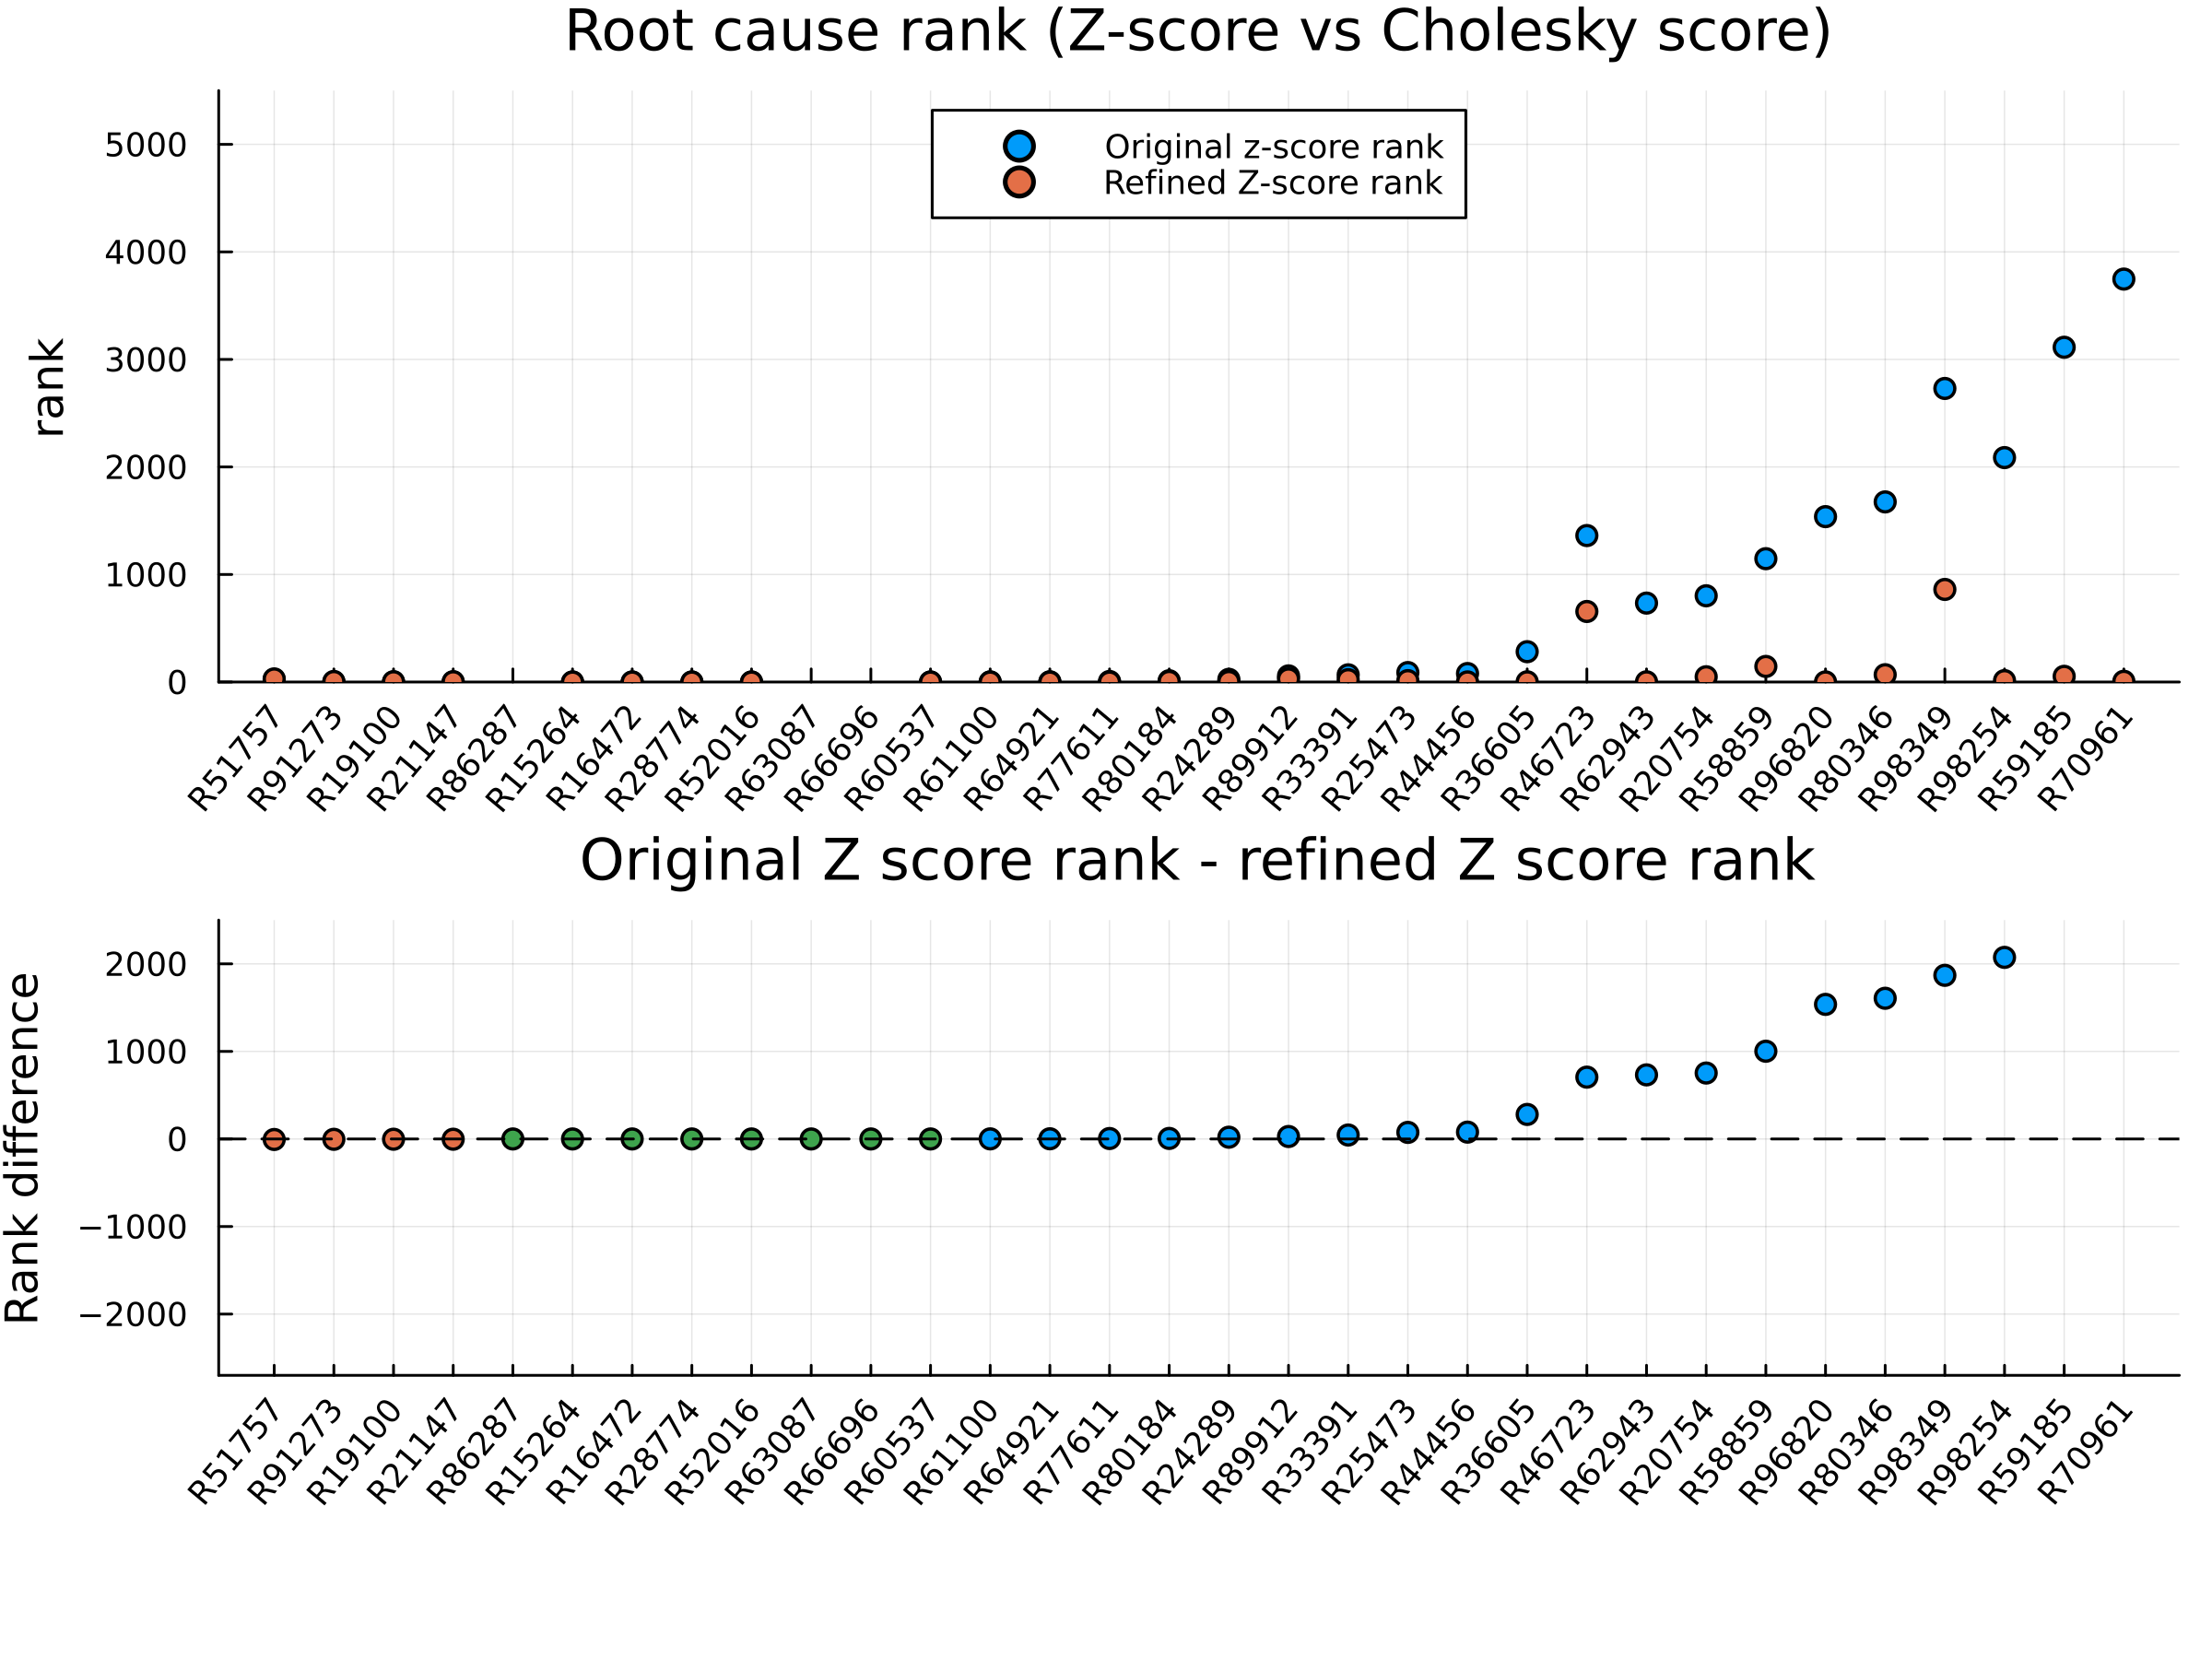

In [5]:
cv_outdir = "/scratch/users/bbchu/RootCauseDiscovery/7.29.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[],
    "RC Z-score"=>Float64[],
    "RC cholesky score"=>Float64[],
)

# compare our method against z score method
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # cv result
        file = joinpath(cv_outdir, "$id.csv")
        cholesky_score = readdlm(file)
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank_cv = count(x -> x > root_cause_cholesky_score, cholesky_score)
        
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank_cv, 
                       round(patient_root_cause_zscore, digits=3), round(root_cause_cholesky_score, digits=3)])
    catch e
        println(e)
        continue
    end
end

# @show length(cholesky_score)
@show df;

# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 6.27.2024 (`nshuffle = 50`)

+ low_count = 10
+ threshold = 0.1

Progress:  47%|███████████████████▎                     |  ETA: 0:00:05

ArgumentError(

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/6.27.2024/cv/R60537.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/6.27.2024/cv/R70961.jld2")
df = 30×5 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank  RC Z-score  RC cholesky score
     │ String        Float64                Float64              Float64     Float64
─────┼─────────────────────────────────────────────────────────────────────────────────────────
   1 │ R62943                        739.0                  3.0       2.304              7.74
   2 │ R98254                       2111.0                 14.0       2.395              3.875
   3 │ R86287                      14630.0              14630.0       0.199              0.0
   4 │ R89912                         58.0                 19.0       9.179              4.672
   5 │ R19100                          0.0                  0.0      23.514              8.205
   6 │ R15264         

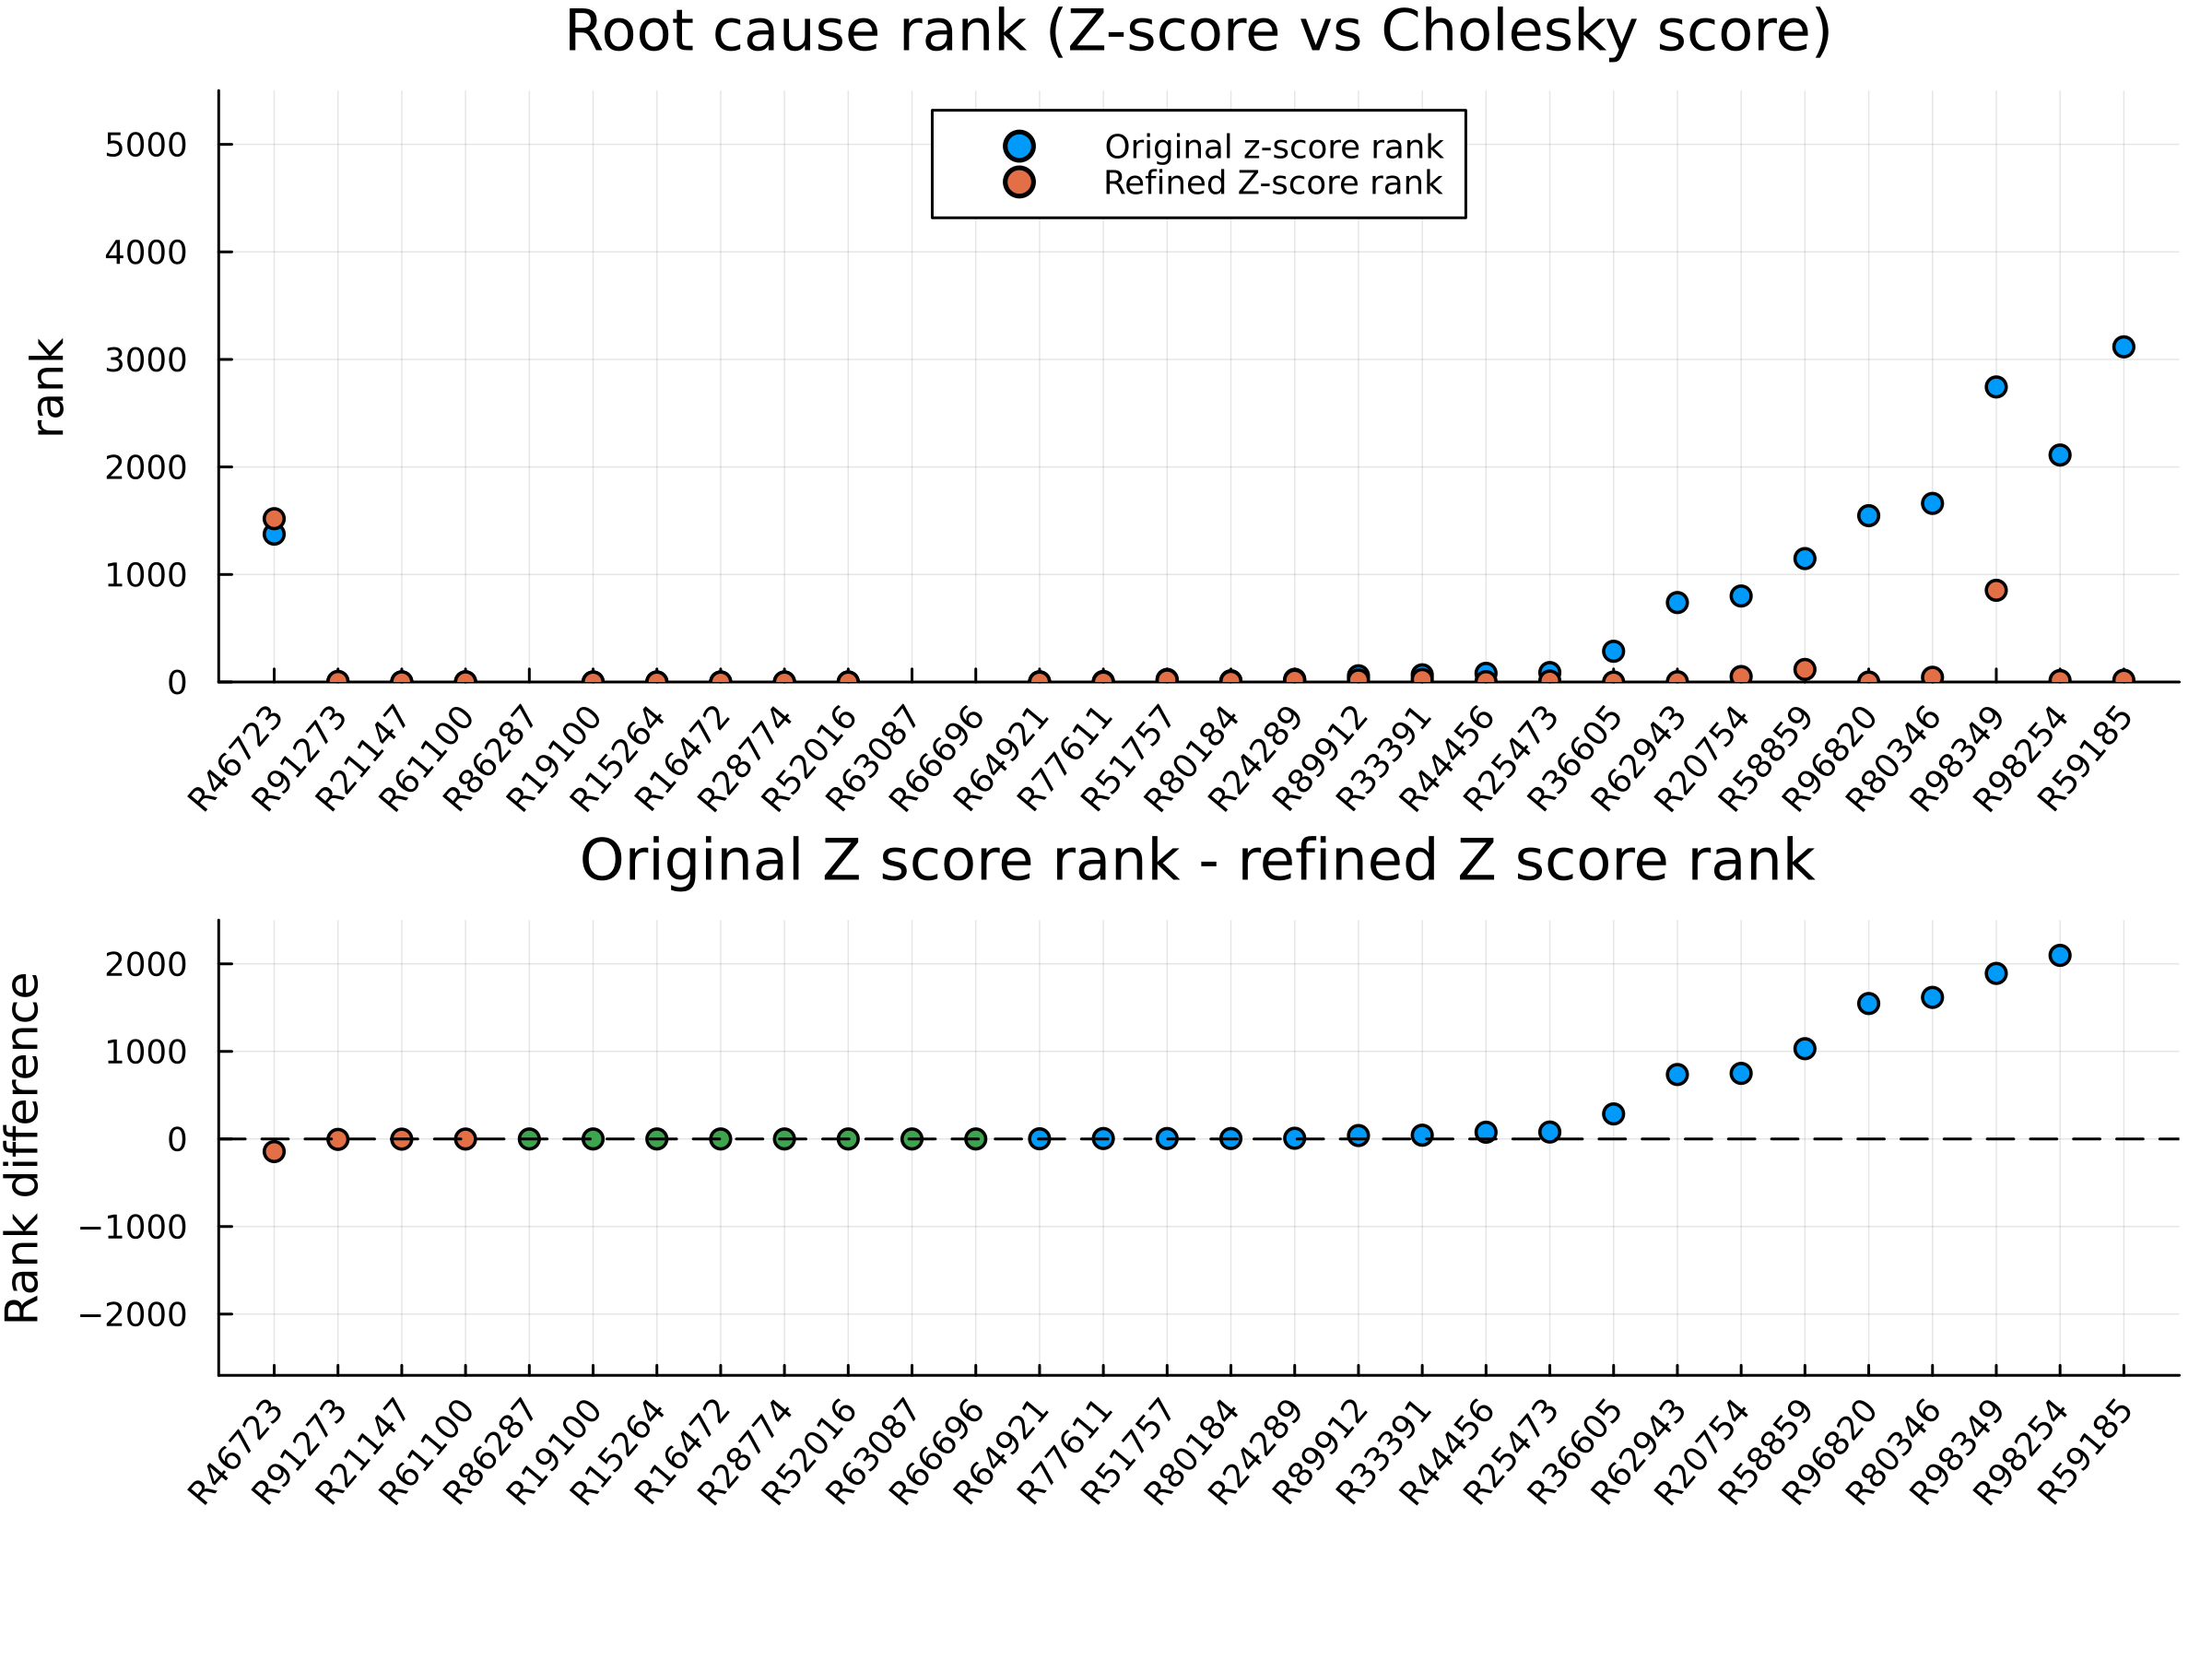

In [4]:
cv_outdir = "/scratch/users/bbchu/RootCauseDiscovery/6.27.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[],
    "RC Z-score"=>Float64[],
    "RC cholesky score"=>Float64[],
)

# compare our method against z score method
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # cv result
        jld2_file = joinpath(cv_outdir, "$id.jld2")
        cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank_cv = count(x -> x > root_cause_cholesky_score, cholesky_score)
        
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank_cv, 
                       round(patient_root_cause_zscore, digits=3), round(root_cause_cholesky_score, digits=3)])
    catch e
        println(e)
        continue
    end
end

# @show length(cholesky_score)
@show df;

# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 6.18.2024

+ low_count = 10
+ threshold = 0.1

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


df = 32×5 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank  RC Z-score  RC cholesky score
     │ String        Float64                Float64              Float64     Float64
─────┼─────────────────────────────────────────────────────────────────────────────────────────
   1 │ R62943                        739.0                  4.0       2.304              6.434
   2 │ R98254                       2111.0                 14.0       2.395              3.8
   3 │ R86287                      14630.0              14630.0       0.199              0.0
   4 │ R89912                         58.0                 13.0       9.179              4.724
   5 │ R19100                          0.0                  0.0      23.514             10.032
   6 │ R15264                          0.0                  0.0     100.198             20.423
   7 │ R36605                        286.0                  7.0       5.115              5.498
   8 │ R61100                          1.0 

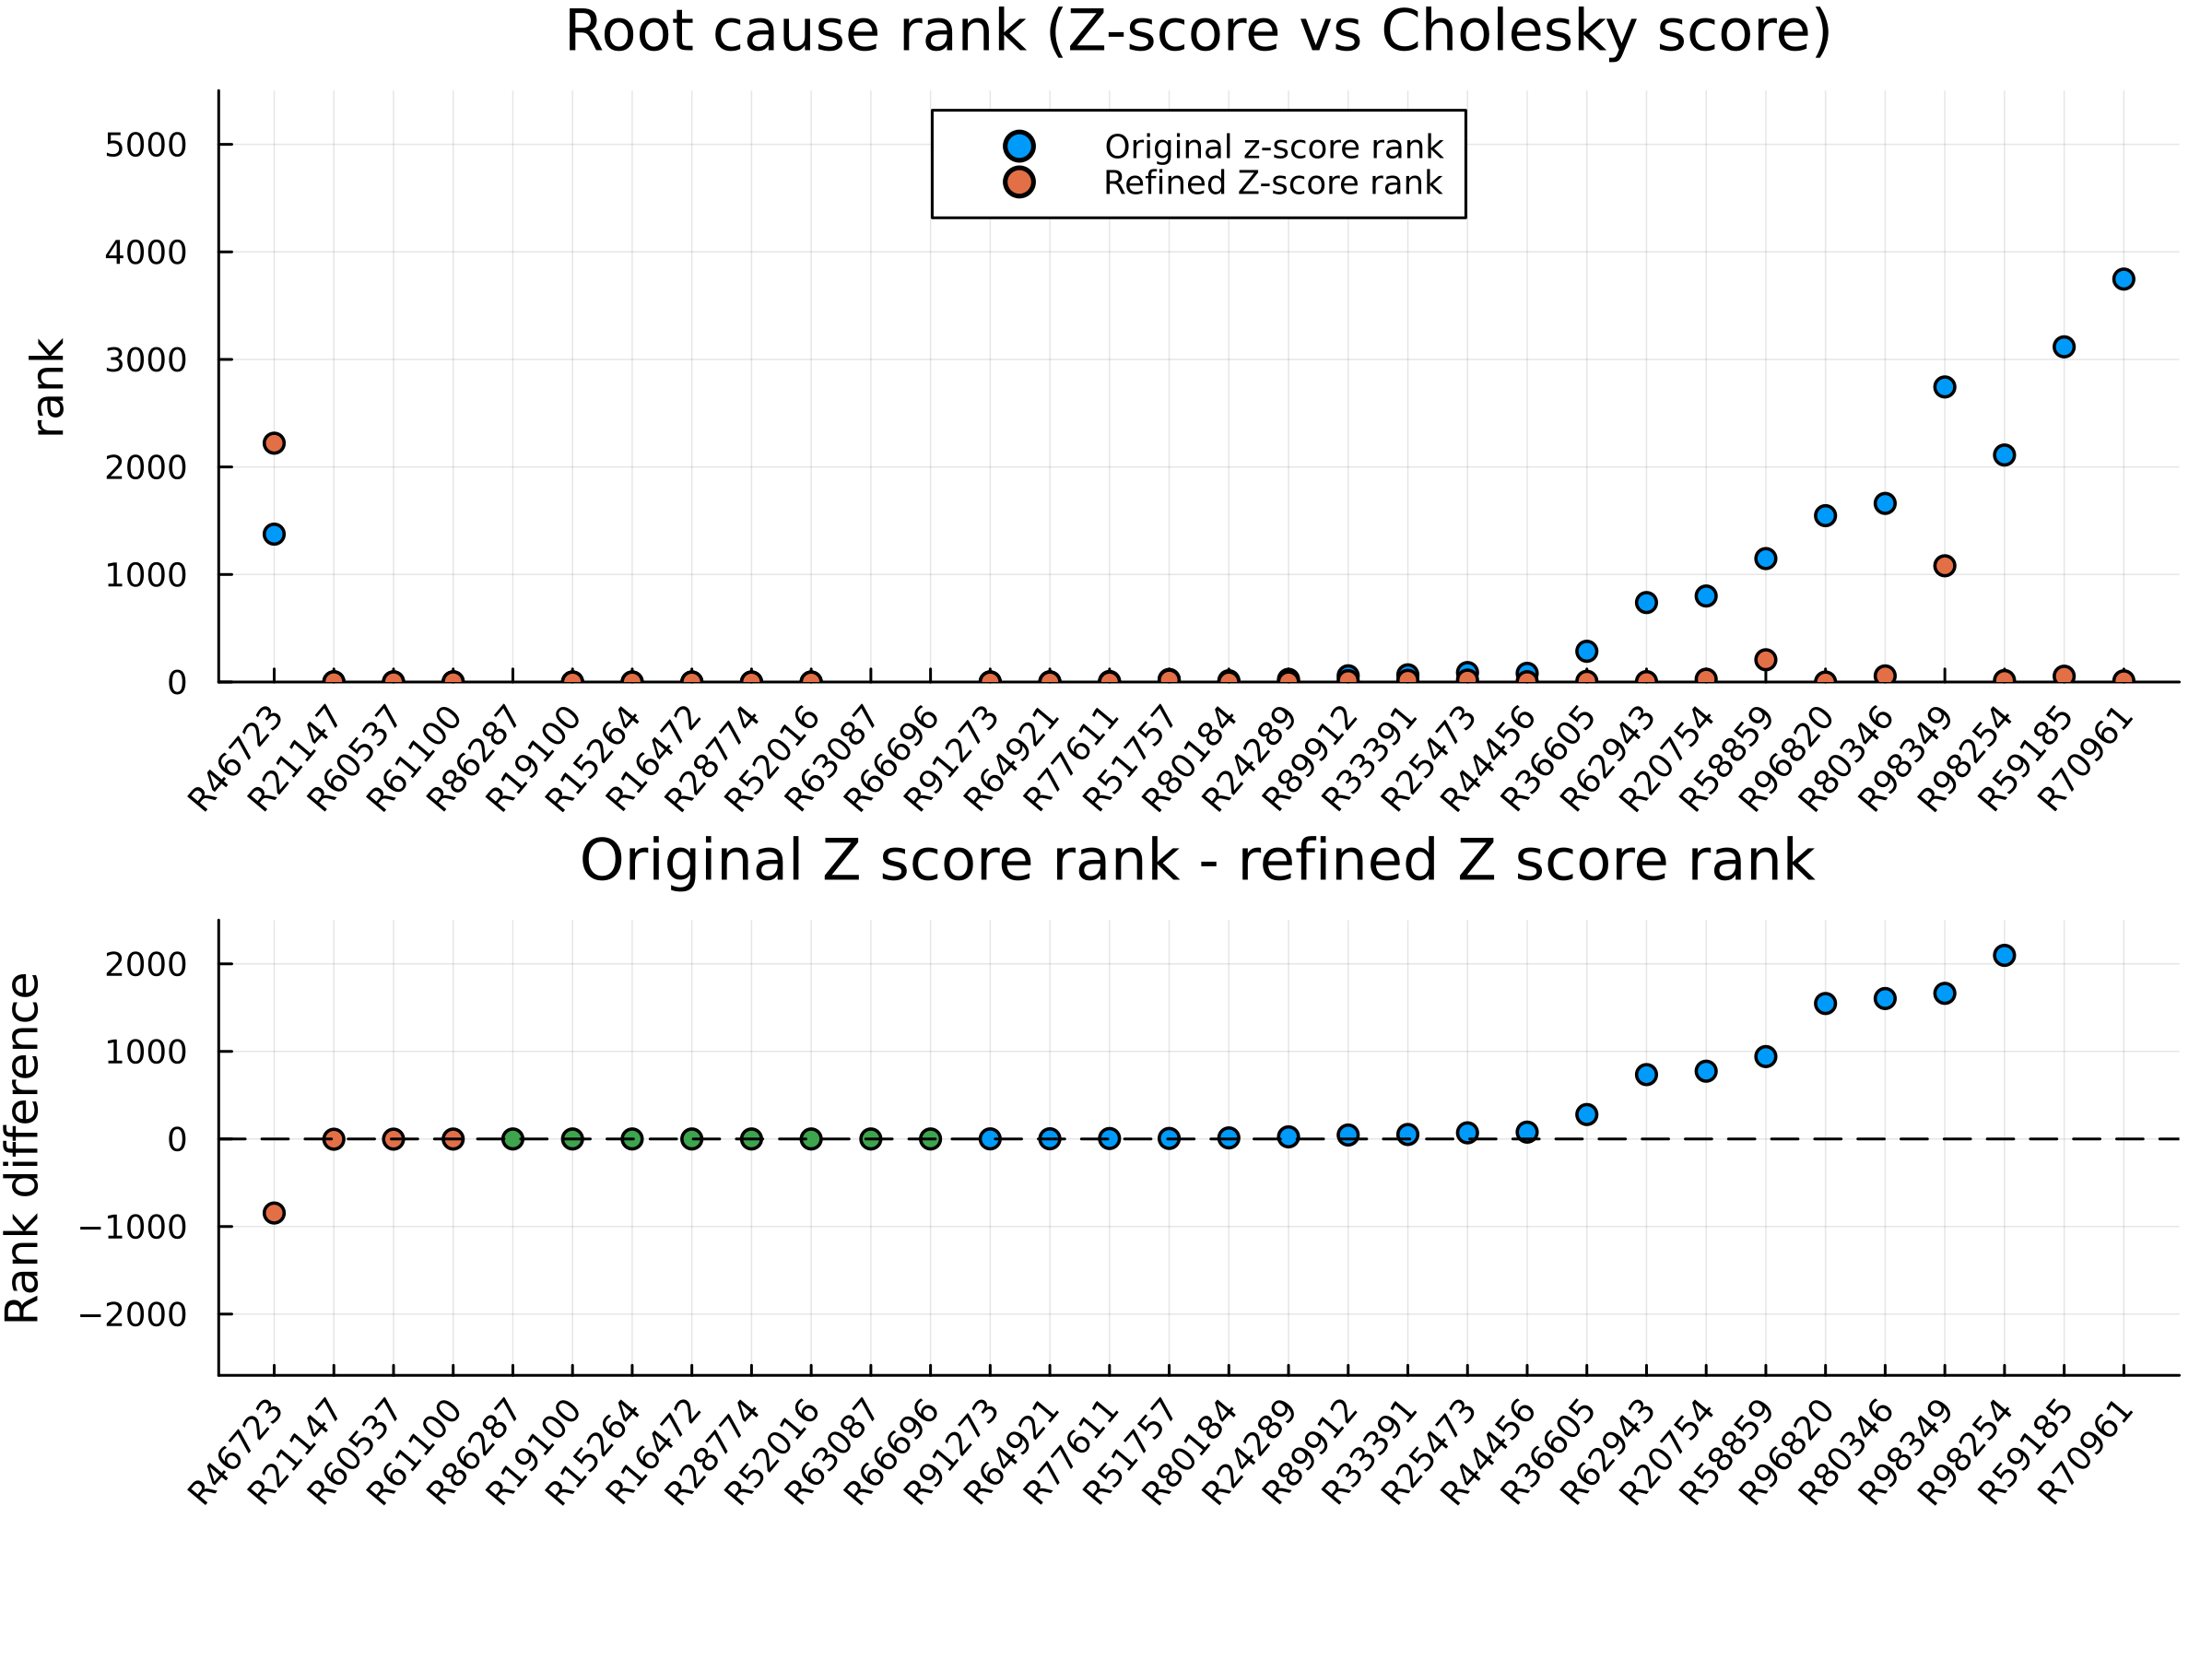

In [7]:
cv_outdir = "/scratch/users/bbchu/RootCauseDiscovery/6.18.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[],
    "RC Z-score"=>Float64[],
    "RC cholesky score"=>Float64[],
)

# compare our method against z score method
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # cv result
        jld2_file = joinpath(cv_outdir, "$id.jld2")
        cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank_cv = count(x -> x > root_cause_cholesky_score, cholesky_score)
        
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank_cv, 
                       round(patient_root_cause_zscore, digits=3), round(root_cause_cholesky_score, digits=3)])
    catch e
        println(e)
        continue
    end
end

# @show length(cholesky_score)
@show df;

# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 6.17.2024

+ low_count = 10
+ threshold = 0.1

df = 32×5 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank  RC Z-score  RC cholesky score
     │ String        Float64                Float64              Float64     Float64
─────┼─────────────────────────────────────────────────────────────────────────────────────────
   1 │ R62943                        739.0                  3.0       2.304              7.841
   2 │ R98254                       2111.0                 14.0       2.395              3.909
   3 │ R86287                      14630.0              14630.0       0.199              0.0
   4 │ R89912                         58.0                  6.0       9.179              7.016
   5 │ R19100                          0.0                  0.0      23.514             10.688
   6 │ R15264                          0.0                  0.0     100.198             22.277
   7 │ R36605                        286.0                  0.0       5.115              8.741
   8 │ R61100                          1.

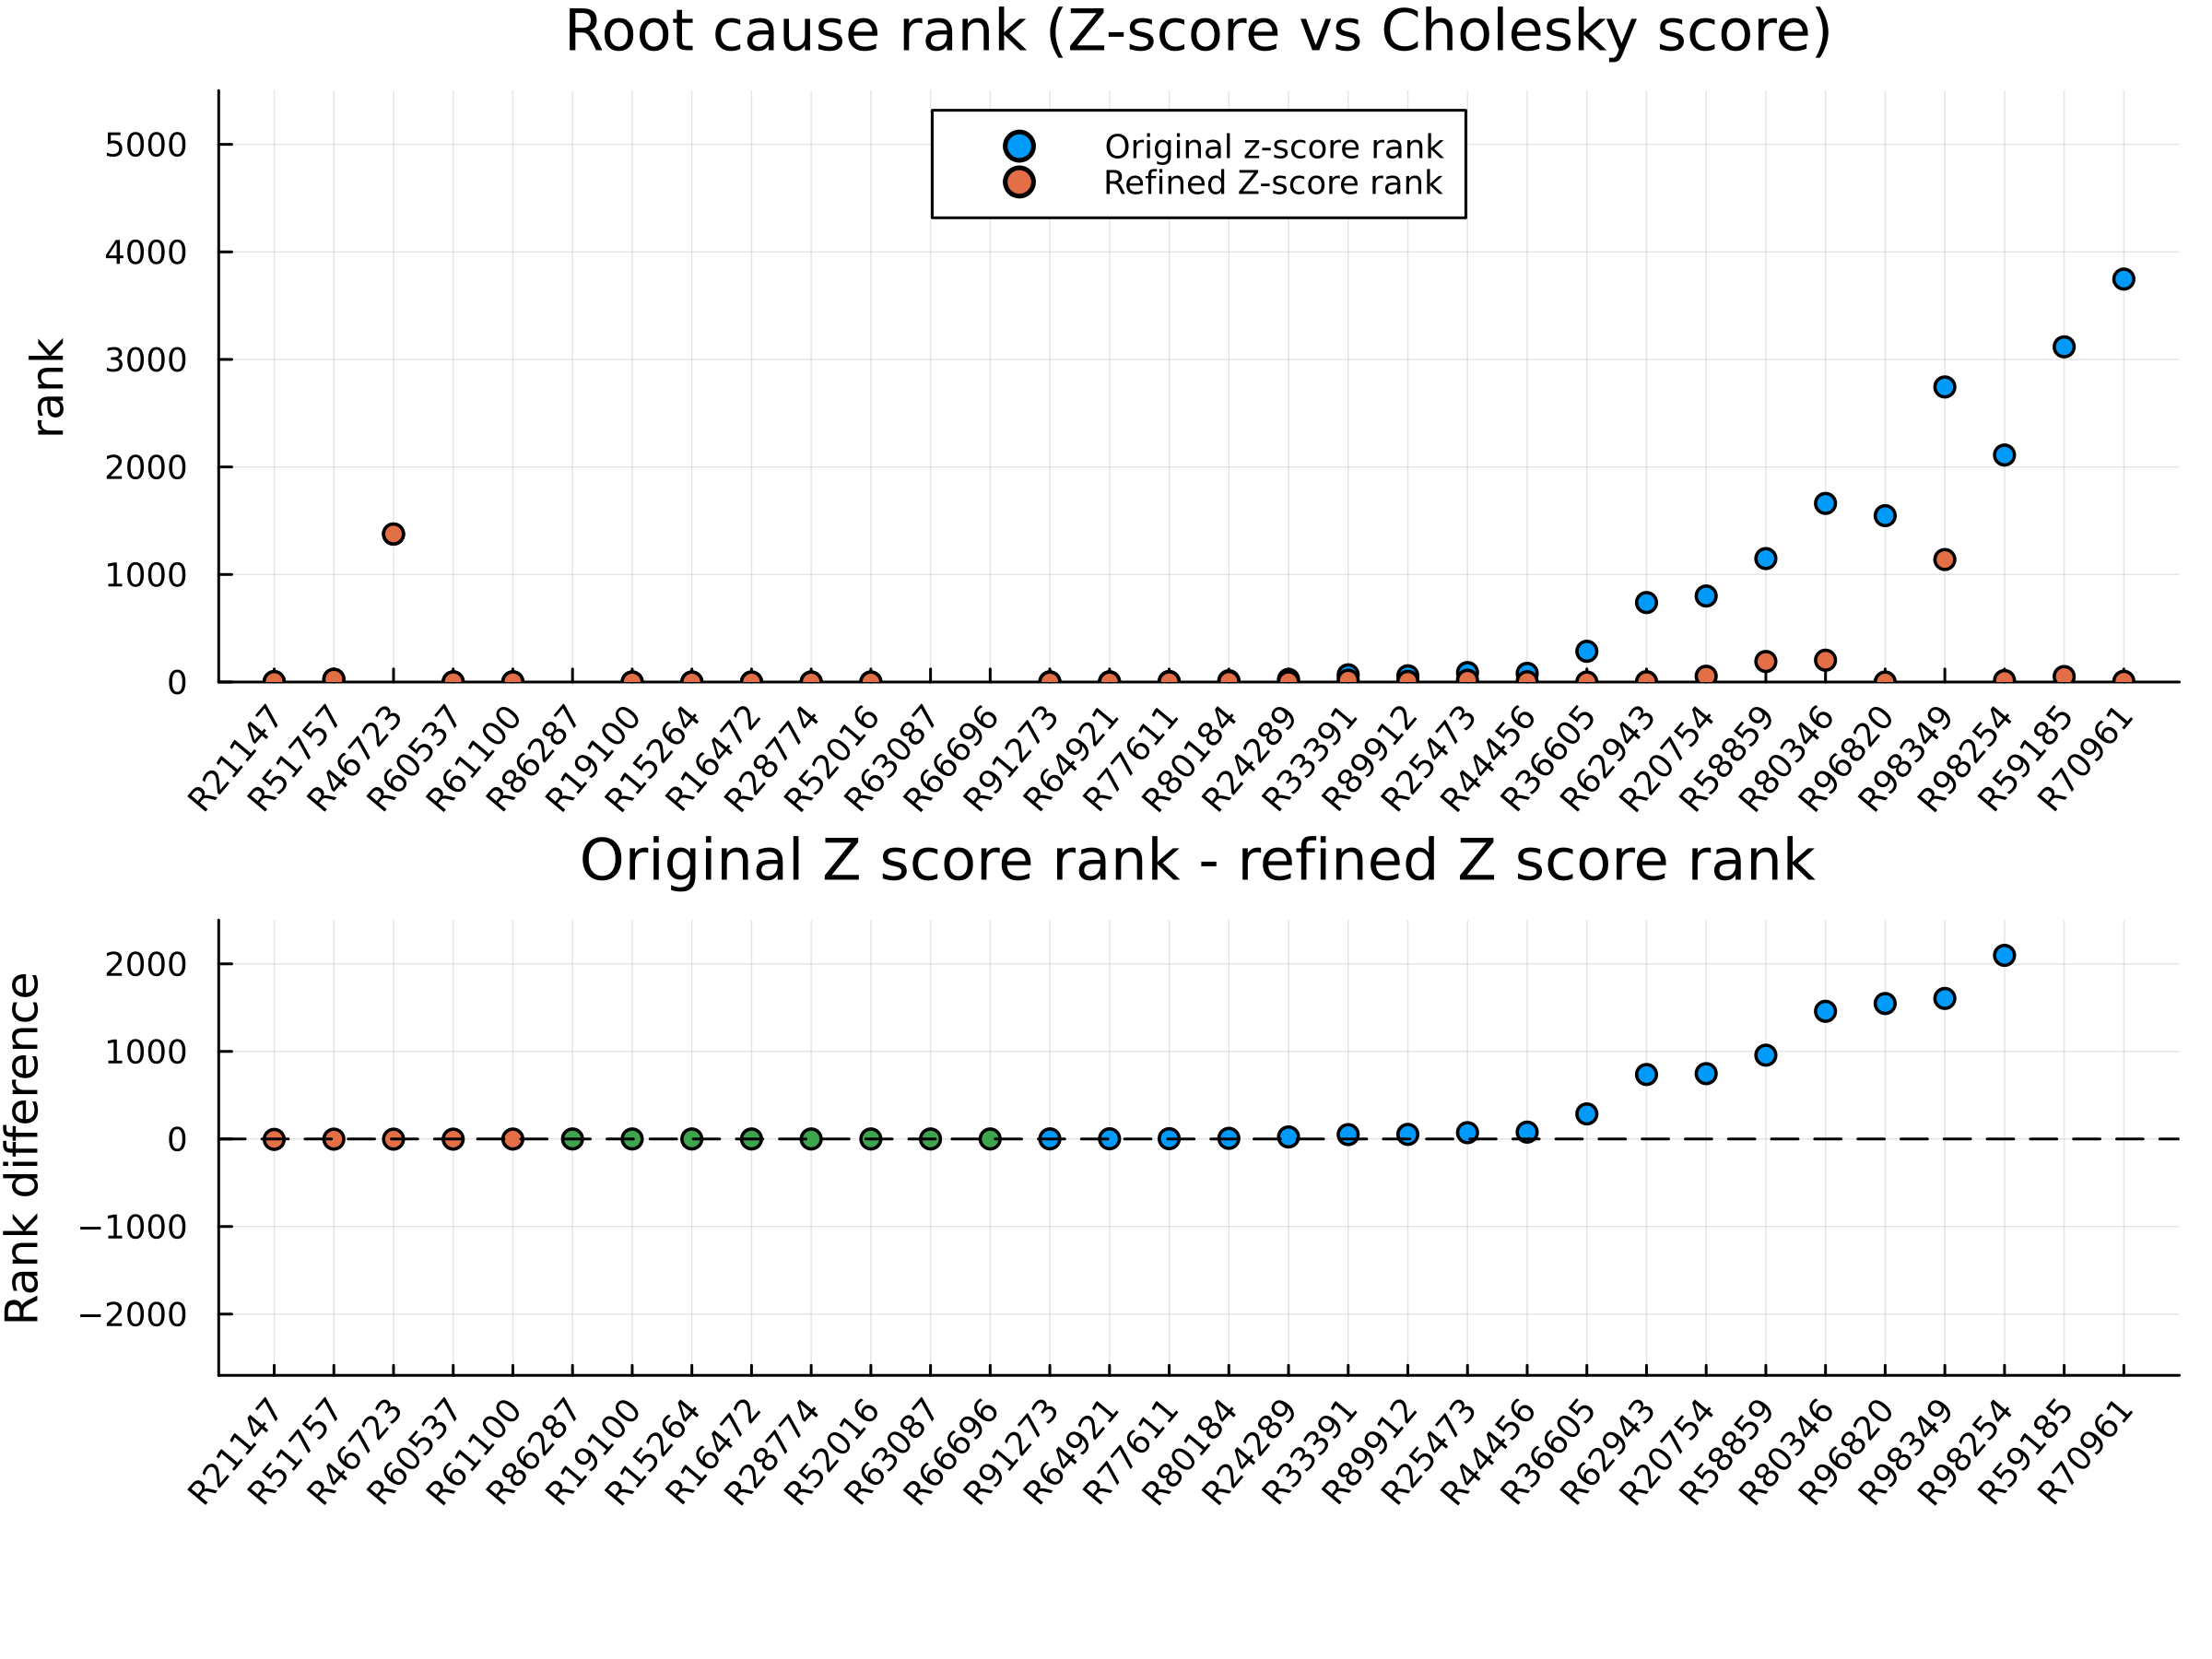

In [15]:
cv_outdir = "/scratch/users/bbchu/RootCauseDiscovery/6.17.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[],
    "RC Z-score"=>Float64[],
    "RC cholesky score"=>Float64[],
)

# compare our method against z score method
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # cv result
        jld2_file = joinpath(cv_outdir, "$id.jld2")
        cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank_cv = count(x -> x > root_cause_cholesky_score, cholesky_score)
        
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank_cv, 
                       round(patient_root_cause_zscore, digits=3), round(root_cause_cholesky_score, digits=3)])
    catch e
        println(e)
        continue
    end
end

# @show length(cholesky_score)
@show df;

# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

## Save result

In [6]:
# final ranking
CSV.write("/scratch/users/bbchu/RootCauseDiscovery/7.29.2024/cv_result.csv", df)

"/scratch/users/bbchu/RootCauseDiscovery/7.29.2024/cv_result.csv"

Also save Z-scores

In [7]:
z = RootCauseDiscovery.zscore(Xobs, Xint)
writedlm("/scratch/users/bbchu/RootCauseDiscovery/7.29.2024/zscore.csv", z)